In [1]:
import os

import unyt
import swiftsimio as sw
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def find_nearest_idx(x,arr):
    diff_arr = np.absolute(arr-x)
    index = diff_arr.argmin()
    return index

In [5]:
colibre_base_path = "/mnt/su3-pro/colibre/"
simulation_dir = "L0025N0752/THERMAL_AGN"

soap_path = "SOAP/halo_properties_0123.hdf5"
soap_catalogue_file = os.path.join(colibre_base_path, simulation_dir, soap_path)

catalogue = sw.load(soap_catalogue_file)

#catalogue = sw.load("cosma_files/L012_m6/THERMAL_AGN_m6/SOAP/halo_properties_0127.hdf5")
#dir(catalogue)

In [6]:
meta = catalogue.metadata
#dir(meta)

In [7]:
boxsize=meta.boxsize
z=meta.redshift
z_short = round(z,3)

# extracting universe age from metadata - should be ~13.8 at z=0

t = meta.cosmology_raw['Universe age [internal units]'][0] * unyt.Mpc * unyt.s / unyt.km
t.convert_to_units(unyt.Gyr)


In [8]:
# all particles within a bound subhalo AND a 30kpc radius
COM = catalogue.exclusive_sphere_30kpc.centre_of_mass
Mstar = catalogue.exclusive_sphere_30kpc.stellar_mass
SFR = catalogue.exclusive_sphere_30kpc.star_formation_rate
kappa_corot = catalogue.exclusive_sphere_30kpc.kappa_corot_stars
kappa_corot_gas = catalogue.exclusive_sphere_30kpc.kappa_corot_gas
kappa_corot_bary = catalogue.exclusive_sphere_30kpc.kappa_corot_baryons
disk_fraction = catalogue.exclusive_sphere_30kpc.disc_to_total_stellar_mass_fraction
Mgas = catalogue.exclusive_sphere_30kpc.gas_mass
Mmolgas = catalogue.exclusive_sphere_30kpc.molecular_hydrogen_mass

gas_fraction = Mgas/(Mstar+Mgas) #uhhh I might've defined this wrong
mu_gas = Mgas/Mstar

mu_molgas = Mmolgas/Mstar

# initially used bound_subhalo - moved onto exclusive_sphere

/home/jmcgregor/envs/colibre_env/lib/python3.10/site-packages/unyt/array.py:1972: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
/home/jmcgregor/envs/colibre_env/lib/python3.10/site-packages/unyt/array.py:1972: RuntimeWarning: divide by zero encountered in divide
  out_arr = func(


In [9]:
starmask = Mstar > 0

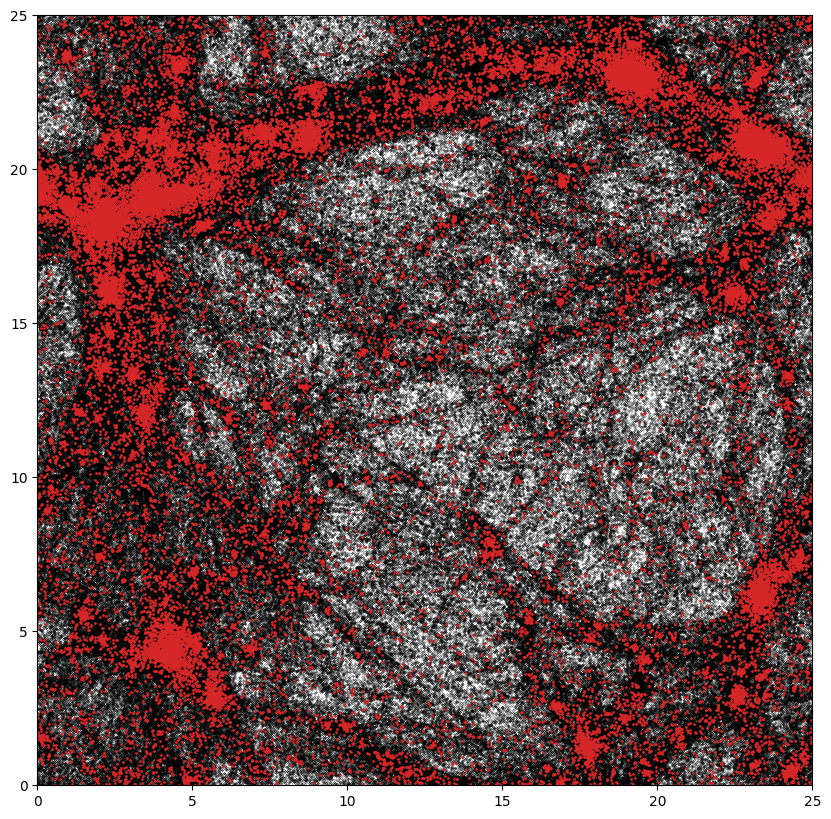

In [10]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(COM[:,0],COM[:,1],s=0.05,c='k') # all subhalos
ax.scatter(COM[starmask,0],COM[starmask,1],s=1,c='C3') # those containing some stellar mass
ax.set_xlim((0,boxsize[0]))
ax.set_ylim((0,boxsize[1]))

plt.show()

In [11]:
# based on Popesso+23
SFMS_masses = np.logspace(8.5,11.5,100) * unyt.Msun
m = np.log10(SFMS_masses/unyt.Msun) + 0.025
tdim = t/unyt.Gyr
MSMZ = (-0.034*tdim+4.722)*m - 0.1925*m**2 + (0.2*tdim-26.16)
SFMS_SFRs = 10**MSMZ * (unyt.Msun/unyt.yr)


# based on Evgenii's profiles
data = np.load("./COLIBRE_SFMS_m6res.npz")
logSFR = data["log10_SFR_Msun_yr"]
logMstar = data["log10_Mstar_Msun"]
redshifts = data["redshifts"]

zidx = find_nearest_idx(z,redshifts)
zSFMS = logSFR[:,zidx]

# step function
# note - may fail at z=5 due to missing final bin
def evg_SFMS2(mstar):
    lgmstar = np.log10(mstar/unyt.Msun)
    midx = [find_nearest_idx(x, logMstar) for x in lgmstar]
    lgSFR = zSFMS[midx]
    evg_SFR = 10**lgSFR * (unyt.Msun/unyt.yr)
    return(evg_SFR)

SFMS_SFRs2 = evg_SFMS2(SFMS_masses)

# 2nd order polynomial
a,b,c = np.polyfit(logMstar,zSFMS,deg=2)
def evg_SFMS3(mstar):
    lgmstar = np.log10(mstar/unyt.Msun)
    lgSFR = a*lgmstar**2 + b*lgmstar + c
    evg_SFR = 10**lgSFR * (unyt.Msun/unyt.yr)
    return(evg_SFR)

SFMS_SFRs3 = evg_SFMS3(SFMS_masses)


In [12]:
print(a,b,c)

-0.32005707578889336 6.8792532391476495 -36.85744445177137


In [13]:
masscut = 10**9.5 * unyt.Msun
softmasscut = 10**8.5 * unyt.Msun # galaxies below this don't have an accurate SFMS
dMScut = -0.3 # based on typical SFMS scatter
kappacut = 0.4

m = np.log10(Mstar/unyt.Msun) + 0.025
SFR_MS = 10**((-0.034*tdim+4.722)*m - 0.1925*m**2 + (0.2*tdim-26.16)) * (unyt.Msun/unyt.yr) # bestfit from Popesso+23
deltaMS = np.log10(SFR/SFR_MS)


selection = (Mstar>masscut) & (deltaMS>dMScut) & (kappa_corot>kappacut)
softselection = Mstar>softmasscut

/home/jmcgregor/envs/colibre_env/lib/python3.10/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/home/jmcgregor/envs/colibre_env/lib/python3.10/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (1 at a=0.9999999999999997) for all arguments.
  warnings.warn(


In [ ]:
candidates = np.argwhere(selection) # finding the ID of our galaxies
target = candidates[0][0]
print(target)

479


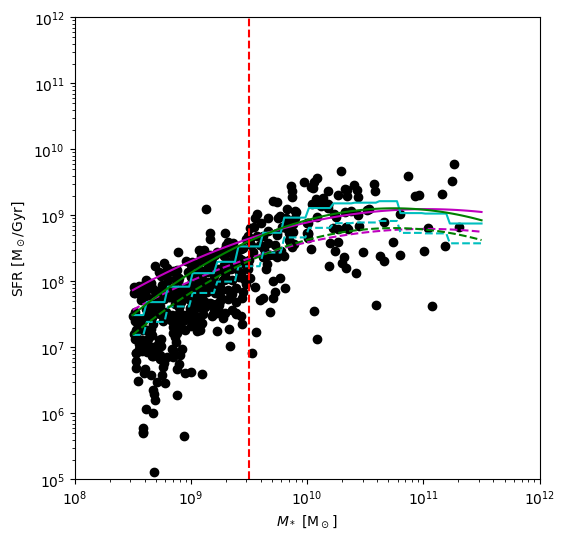

In [41]:
mass_lo=1e8
mass_hi=1e12
SFR_lo=1e5
SFR_hi=1e12
dMS_lo=-3
dMS_hi=1
kappa_lo=0
kappa_hi=1
gasfrac_lo=1e-2
gasfrac_hi=1e0
mumolgas_lo=1e-3
mumolgas_hi=1e1

unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:

    fig,ax = plt.subplots(1,1,figsize=(6,6))

    ax.scatter(Mstar[softselection],SFR[softselection], xunits='Msun',yunits='Msun/Gyr',c='k')
    #ax.scatter(Mstar[selection],SFR[selection], xunits='Msun',yunits='Msun/Gyr',c='r')
    #ax.scatter(Mstar[target],SFR[target], xunits='Msun',yunits='Msun/Gyr',c='b',marker='*',s=200)
    ax.plot(SFMS_masses,SFMS_SFRs,'m')
    ax.plot(SFMS_masses,SFMS_SFRs*10**dMScut,'m--')
    ax.plot(SFMS_masses,SFMS_SFRs2,'c')
    ax.plot(SFMS_masses,SFMS_SFRs2*10**dMScut,'c--')
    ax.plot(SFMS_masses,SFMS_SFRs3,'g')
    ax.plot(SFMS_masses,SFMS_SFRs3*10**dMScut,'g--')
    ax.vlines(x=masscut,ymin=SFR_lo,ymax=SFR_hi,colors='r',linestyles='--')
    ax.set_xscale('log')
    ax.set_xlim(mass_lo,mass_hi)
    ax.set_xlabel(r'$M_*$ [M$_\odot$]')
    ax.set_yscale('log')
    ax.set_ylim(SFR_lo,SFR_hi)
    ax.set_ylabel(r'SFR [M$_\odot$/Gyr]')

    plt.show()

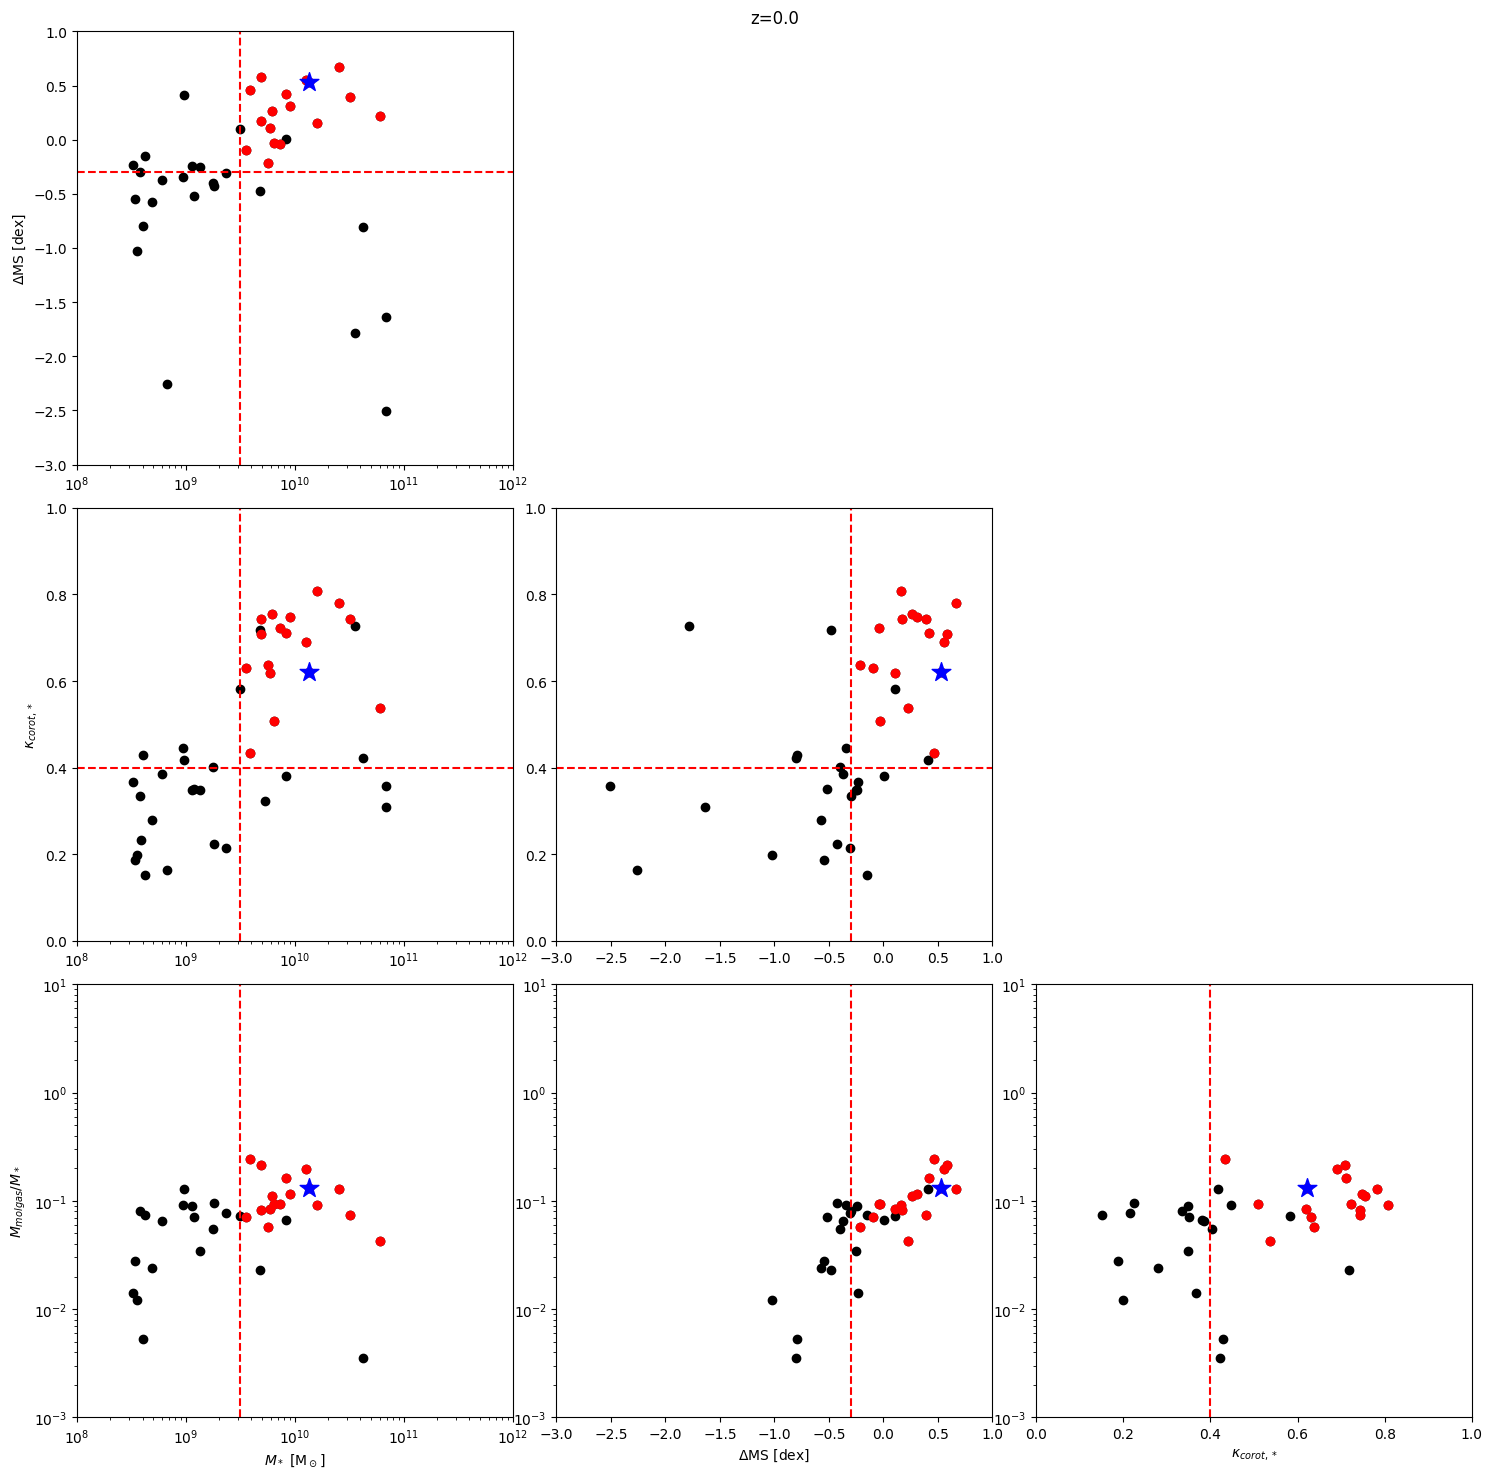

In [20]:
unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:

    fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(18,18))

    ax1.scatter(Mstar[softselection],deltaMS[softselection], xunits='Msun',c='k')
    ax1.scatter(Mstar[selection],deltaMS[selection], xunits='Msun',c='r')
    ax1.scatter(Mstar[target],deltaMS[target], xunits='Msun',c='b',marker='*',s=200)
    ax1.vlines(x=masscut,ymin=dMS_lo,ymax=dMS_hi,colors='r',linestyles='--')
    ax1.hlines(y=dMScut,xmin=mass_lo,xmax=mass_hi,colors='r',linestyles='--')
    ax1.set_xscale('log')
    ax1.set_xlim(mass_lo,mass_hi)
    ax1.set_xlabel('')
    #ax1.set_xlabel(r'$M_*$ [M$_\odot$]')
    ax1.set_ylim(dMS_lo,dMS_hi)
    ax1.set_ylabel(r'$\Delta$MS [dex]')

    ax2.set_title('z='+str(z_short))
    ax2.set_axis_off()

    ax3.set_axis_off()

    ax4.scatter(Mstar[softselection],kappa_corot[softselection], xunits='Msun',c='k')
    ax4.scatter(Mstar[selection],kappa_corot[selection], xunits='Msun',c='r')
    ax4.scatter(Mstar[target],kappa_corot[target], xunits='Msun',c='b',marker='*',s=200)
    ax4.vlines(x=masscut,ymin=kappa_lo,ymax=kappa_hi,colors='r',linestyles='--')
    ax4.hlines(y=kappacut,xmin=mass_lo,xmax=mass_hi,colors='r',linestyles='--')
    ax4.set_xscale('log')
    ax4.set_xlim(mass_lo,mass_hi)
    ax4.set_xlabel('')
    #ax4.set_xlabel(r'$M_*$ [M$_\odot$]')
    ax4.set_ylim(kappa_lo,kappa_hi)
    ax4.set_ylabel(r'$\kappa_{corot,*}$')

    ax5.scatter(deltaMS[softselection],kappa_corot[softselection],c='k')
    ax5.scatter(deltaMS[selection],kappa_corot[selection],c='r')
    ax5.scatter(deltaMS[target],kappa_corot[target],c='b',marker='*',s=200)
    ax5.hlines(y=kappacut,xmin=dMS_lo,xmax=dMS_hi,colors='r',linestyles='--')
    ax5.vlines(x=dMScut,ymin=kappa_lo,ymax=kappa_hi,colors='r',linestyles='--')
    ax5.set_xlim(dMS_lo,dMS_hi)
    ax5.set_xlabel('')
    #ax5.set_xlabel(r'$\Delta$MS [dex]')
    ax5.set_ylim(kappa_lo,kappa_hi)
    ax5.set_ylabel('')
    #ax5.set_ylabel(r'$\kappa_{corot,*}$')

    ax6.set_axis_off()

    ax7.scatter(Mstar[softselection],mu_molgas[softselection], xunits='Msun',c='k')
    ax7.scatter(Mstar[selection],mu_molgas[selection], xunits='Msun',c='r')
    ax7.scatter(Mstar[target],mu_molgas[target], xunits='Msun',c='b',marker='*',s=200)
    ax7.vlines(x=masscut,ymin=mumolgas_lo,ymax=mumolgas_hi,colors='r',linestyles='--')
    ax7.set_xscale('log')
    ax7.set_xlim(mass_lo,mass_hi)
    ax7.set_xlabel(r'$M_*$ [M$_\odot$]')
    ax7.set_yscale('log')
    ax7.set_ylim(mumolgas_lo,mumolgas_hi)
    ax7.set_ylabel(r'$M_{molgas} / M_*$')

    ax8.scatter(deltaMS[softselection],mu_molgas[softselection],c='k')
    ax8.scatter(deltaMS[selection],mu_molgas[selection],c='r')
    ax8.scatter(deltaMS[target],mu_molgas[target],c='b',marker='*',s=200)
    ax8.vlines(x=dMScut,ymin=mumolgas_lo,ymax=mumolgas_hi,colors='r',linestyles='--')
    ax8.set_xlim(dMS_lo,dMS_hi)
    ax8.set_xlabel(r'$\Delta$MS [dex]')
    ax8.set_yscale('log')
    ax8.set_ylim(mumolgas_lo,mumolgas_hi)
    ax8.set_ylabel('')
    #ax8.set_ylabel(r'$M_{gas} / M_*$')

    ax9.scatter(kappa_corot[softselection],mu_molgas[softselection],c='k')
    ax9.scatter(kappa_corot[selection],mu_molgas[selection],c='r')
    ax9.scatter(kappa_corot[target],mu_molgas[target],c='b',marker='*',s=200)
    ax9.vlines(x=kappacut,ymin=mumolgas_lo,ymax=mumolgas_hi,colors='r',linestyles='--')
    ax9.set_xlim(kappa_lo,kappa_hi)
    ax9.set_xlabel(r'$\kappa_{corot,*}$')
    ax9.set_yscale('log')
    ax9.set_ylim(mumolgas_lo,mumolgas_hi)
    ax9.set_ylabel('')
    #ax9.set_ylabel(r'$M_{gas} / M_*$')

    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    
    plt.show()

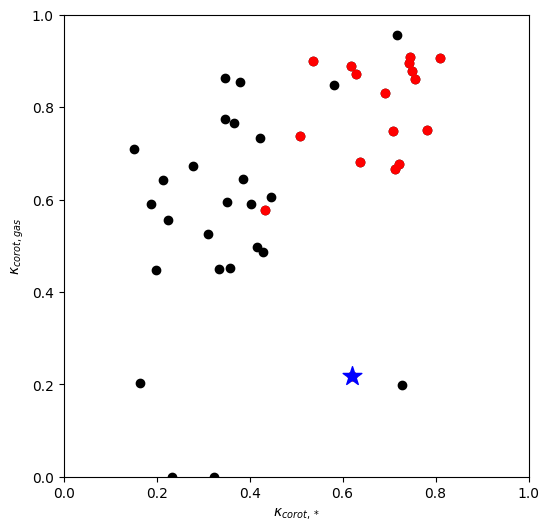

In [27]:
fig,ax = plt.subplots(figsize=(6,6))

ax.scatter(kappa_corot[softselection],kappa_corot_gas[softselection],c='k')
ax.scatter(kappa_corot[selection],kappa_corot_gas[selection],c='r')
ax.scatter(kappa_corot[target],kappa_corot_gas[target],c='b',marker='*',s=200)

ax.set_xlim(0,1)
ax.set_xlabel(r'$\kappa_{corot,*}$')
ax.set_ylim(0,1)
ax.set_ylabel(r'$\kappa_{corot,gas}$')

plt.show()

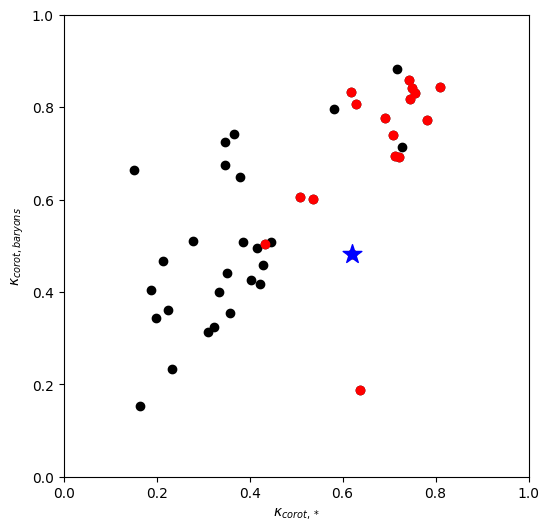

In [30]:
fig,ax = plt.subplots(figsize=(6,6))

ax.scatter(kappa_corot[softselection],kappa_corot_bary[softselection],c='k')
ax.scatter(kappa_corot[selection],kappa_corot_bary[selection],c='r')
ax.scatter(kappa_corot[target],kappa_corot_bary[target],c='b',marker='*',s=200)

ax.set_xlim(0,1)
ax.set_xlabel(r'$\kappa_{corot,*}$')
ax.set_ylim(0,1)
ax.set_ylabel(r'$\kappa_{corot,baryons}$')

plt.show()

In [55]:
# plots explored: 
# Mstar vs disk fraction
# disk fraction vs kappacorot 
# gas fraction vs mass/kappa/deltaMS

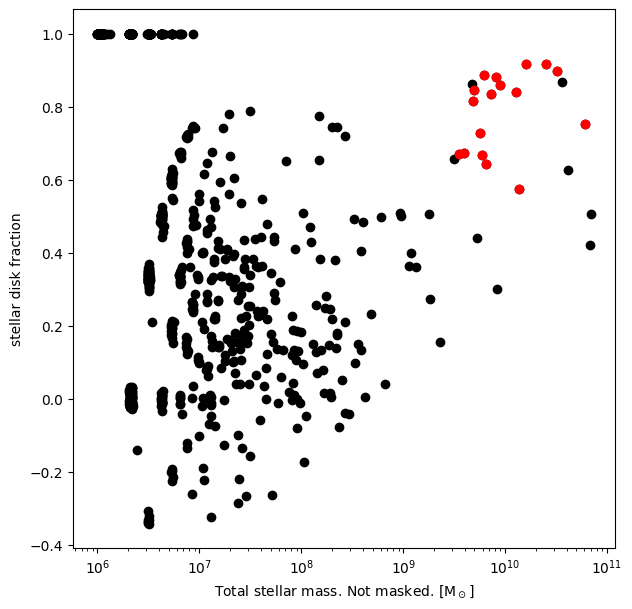

In [56]:
with unyt.matplotlib_support:

    fig,ax = plt.subplots(figsize=(7,7))

    ax.scatter(Mstar,disk_fraction, xunits='Msun',c='k')
    ax.scatter(Mstar[selection],disk_fraction[selection], xunits='Msun',c='r')
    ax.set_xscale('log')
    ax.set_ylabel('stellar disk fraction')

    plt.show()

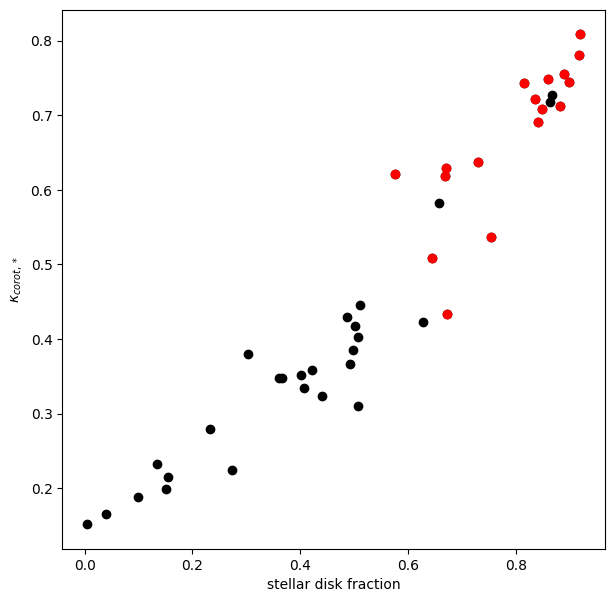

In [57]:
with unyt.matplotlib_support:

    fig,ax = plt.subplots(figsize=(7,7))

    ax.scatter(disk_fraction[softselection], kappa_corot[softselection], c='k')
    ax.scatter(disk_fraction[selection], kappa_corot[selection], c='r')
    ax.set_xlabel('stellar disk fraction')
    ax.set_ylabel(r'$\kappa_{corot,*}$')

    plt.show()

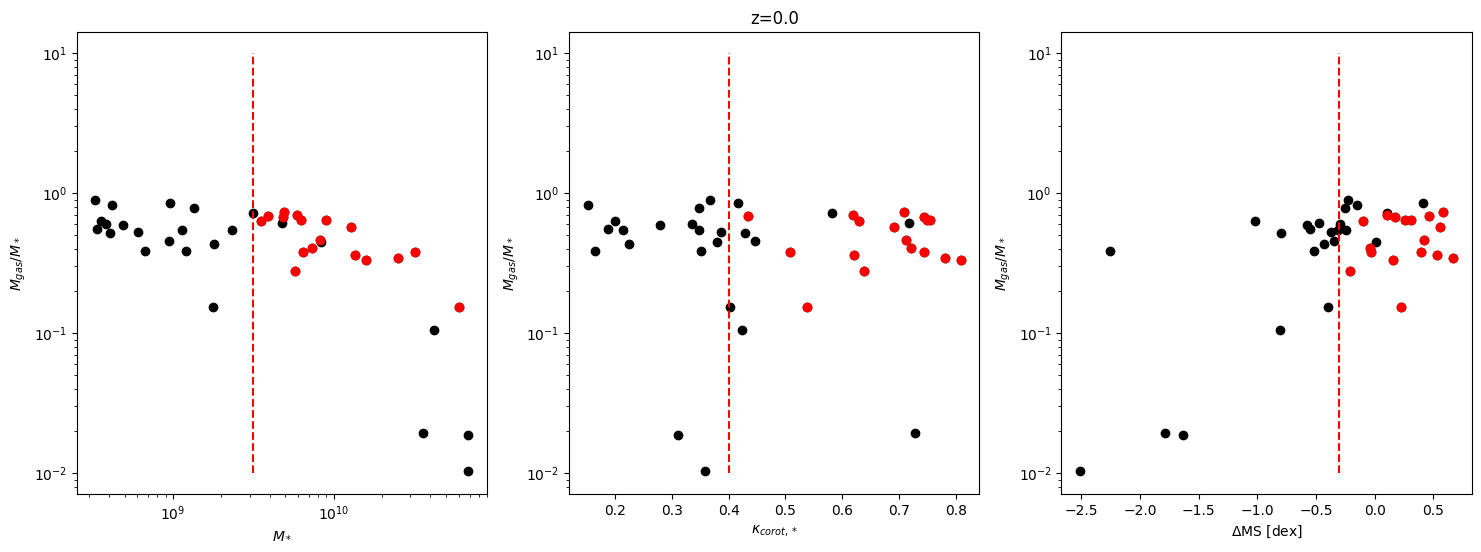

In [58]:
unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:

    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))

    ax1.scatter(Mstar[softselection],gas_fraction[softselection],xunits='Msun',c='k')
    ax1.scatter(Mstar[selection],gas_fraction[selection],xunits='Msun',c='r')
    ax1.vlines(x=masscut,ymin=1e-2,ymax=1e1,colors='r',linestyles='--')
    ax1.set_xlabel(r'$M_*$')
    ax1.set_xscale('log')
    ax1.set_ylabel(r'$M_{gas} / M_*$')
    ax1.set_yscale('log')

    ax2.scatter(kappa_corot[softselection],gas_fraction[softselection],c='k')
    ax2.scatter(kappa_corot[selection],gas_fraction[selection],c='r')
    ax2.vlines(x=kappacut,ymin=1e-2,ymax=1e1,colors='r',linestyles='--')
    ax2.set_xlabel(r'$\kappa_{corot,*}$')
    ax2.set_ylabel(r'$M_{gas} / M_*$')
    ax2.set_yscale('log')
    ax2.set_title('z='+str(z_short))

    ax3.scatter(deltaMS[softselection],gas_fraction[softselection],c='k')
    ax3.scatter(deltaMS[selection],gas_fraction[selection],c='r')
    ax3.vlines(x=dMScut,ymin=1e-2,ymax=1e1,colors='r',linestyles='--')
    ax3.set_xlabel(r'$\Delta$MS [dex]')
    ax3.set_ylabel(r'$M_{gas} / M_*$')
    ax3.set_yscale('log')

    plt.show()

Text(0, 0.5, 'log10 SFR [Msun/yr]')

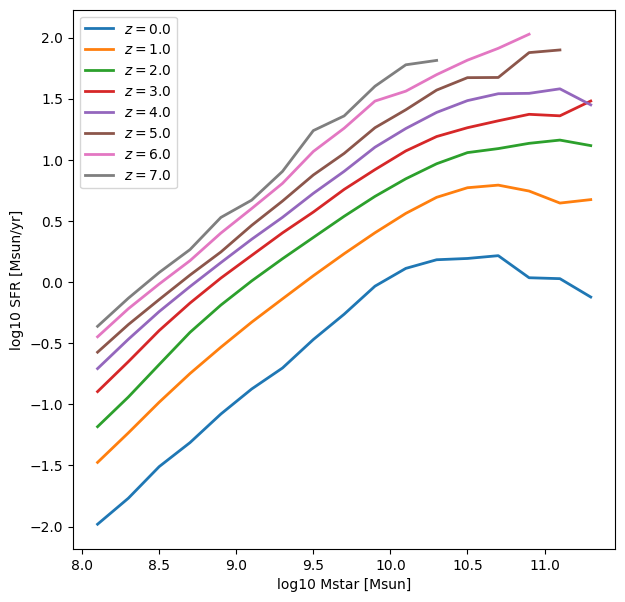

In [41]:
import numpy as np
import matplotlib.pylab as plt

data = np.load("./COLIBRE_SFMS_m6res.npz")

logSFR = data["log10_SFR_Msun_yr"]
logMstar = data["log10_Mstar_Msun"]
redshifts = data["redshifts"]

fig, ax = plt.subplots(1,1, figsize=(7,7))

for counter, z in enumerate(redshifts):

    ax.plot(logMstar, logSFR[:, counter], lw=2, label=f"$z={z:.1f}$")

ax.legend(loc="upper left")
ax.set_xlabel("log10 Mstar [Msun]")
ax.set_ylabel("log10 SFR [Msun/yr]")

In [44]:
data.keys()

KeysView(NpzFile './COLIBRE_SFMS_m6res.npz' with keys: log10_Mstar_Msun, redshifts, log10_SFR_Msun_yr)